In [41]:
import collections
import glob
import itertools
import json
import matplotlib
rc_fonts = {
    "font.size": 14,
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

import s3dexp.db

<IPython.core.display.Javascript object>


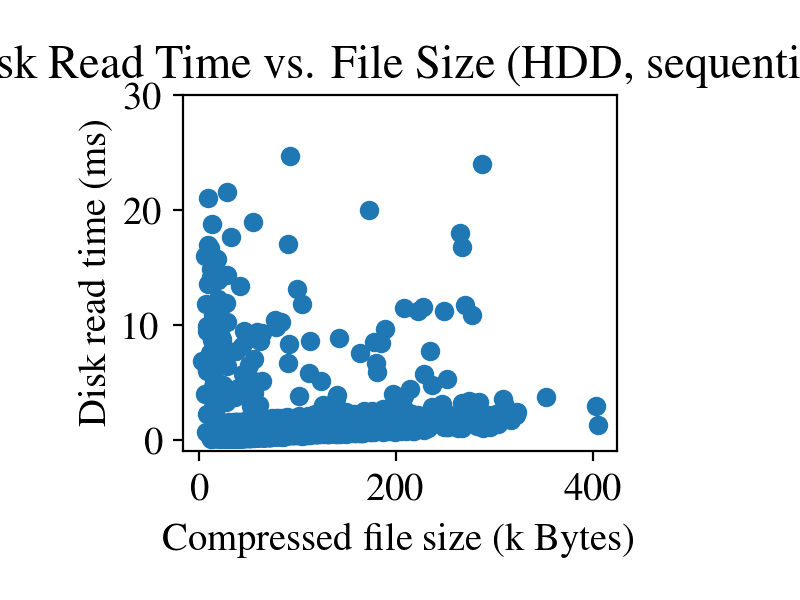

<IPython.core.display.Javascript object>


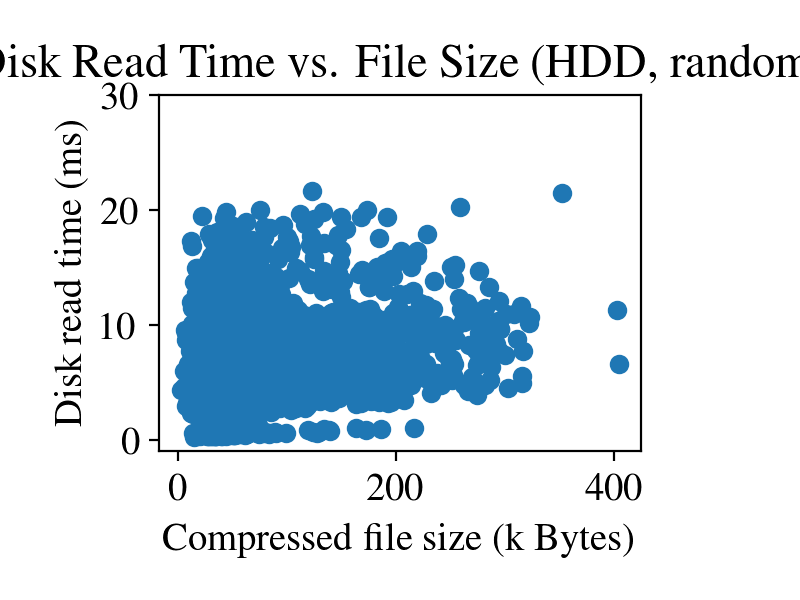

<IPython.core.display.Javascript object>


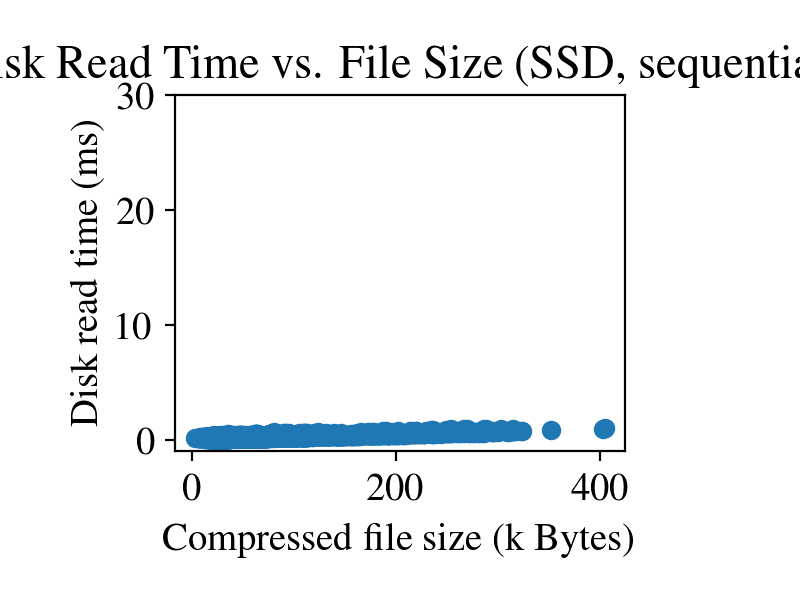

<IPython.core.display.Javascript object>


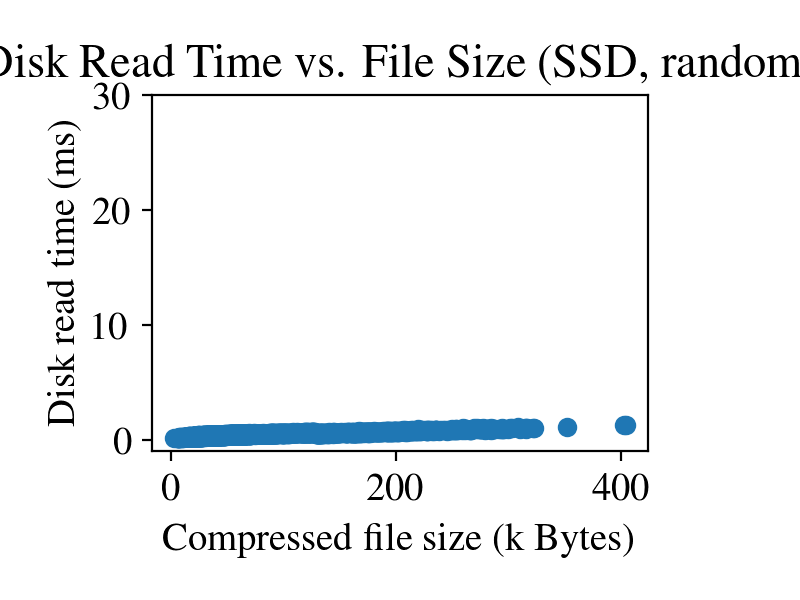

In [37]:
%matplotlib notebook

for disk, disk_text in [('hdd', 'HDD'), ('ssd', 'SSD'),]:
    df = pd.read_sql(
    'SELECT size, rand_read_ms, seq_read_ms, disk \
        FROM DiskReadProfile \
        WHERE disk=%s', 
    s3dexp.db.engine,
    params=[disk,])
    for seq_text, seq_col in [('sequential', 'seq_read_ms'), ('random', 'rand_read_ms')]:
        plt.figure(figsize=(4,3))
        plt.scatter(df['size'] / 1024, df[seq_col])
        plt.xlabel('Compressed file size (k Bytes)')
        plt.ylabel('Disk read time (ms)')
        plt.title('Disk Read Time vs. File Size ({}, {})'.format(disk_text, seq_text))
#         plt.ylim(0.01, 100); plt.yscale('log') #log scale
        plt.ylim(-1, 30)
        plt.tight_layout()
        plt.savefig('readtime-filesize-{}-{}.pdf'.format(disk_text, seq_text), bbox_inches ='tight')

[2.08638397e-06 8.79916063e-02]
Esimated Bus latency is 0.0880 ms


<IPython.core.display.Javascript object>


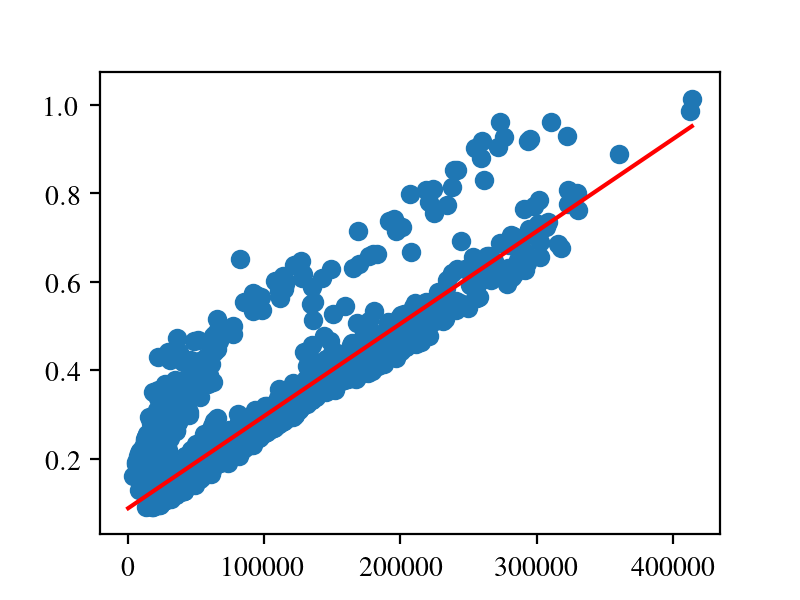

In [33]:
# Find Bus latency using SSD seq read
df = pd.read_sql(
    'SELECT size, seq_read_ms, disk \
        FROM DiskReadProfile \
        WHERE disk=%s', 
    s3dexp.db.engine,
    params=['ssd',])
df.head()

x, y = df['size'], df['seq_read_ms']
coeff = np.polyfit(x,y, deg=1)
print coeff
print "Esimated Bus latency is {:.4f} ms".format(coeff[1])

# note: intercept is coeff[1]

p = np.poly1d(coeff)

plt.figure(figsize=(4,3))
plt.scatter(x, y)
line_x = np.linspace(0, np.max(x), 100)
plt.plot(line_x, p(line_x), 'r-')

<IPython.core.display.Javascript object>


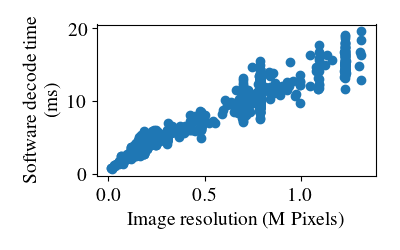

<IPython.core.display.Javascript object>


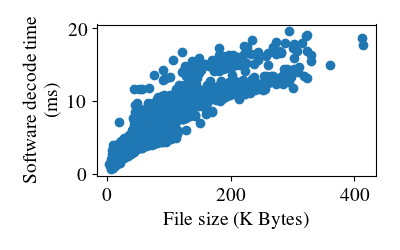

In [48]:
dataset = 'flickr2500'
ext = 'jpg'
df = pd.read_sql(
    'SELECT size, height*width/1000000 as mpix, decode_ms FROM DecodeProfile \
        WHERE path LIKE %s and basename LIKE %s',
    s3dexp.db.engine,
    params=['%{}%'.format(dataset), '%.{}'.format(ext)])

df.describe()

%matplotlib notebook

plt.figure(figsize=(4,2.5))
plt.scatter(df['mpix'], df['decode_ms'])
plt.xlabel('Image resolution (M Pixels)')
plt.ylabel('Software decode time\n(ms)')
# plt.title('Software decoding JPEG images')
plt.tight_layout()
plt.savefig('decodetime-resolution.pdf', bbox_inches ='tight')


plt.figure(figsize=(4,2.5))
plt.scatter(df['size'] / 1000, df['decode_ms'])
plt.xlabel('File size (K Bytes)')
plt.ylabel('Software decode time\n(ms)')
# plt.title('Software decoding JPEG images')
plt.tight_layout()
plt.savefig('decodetime-filesize.pdf', bbox_inches ='tight')